# Power demand anomaly detection

## Introduzione

Lo scopo di questo progetto è quello di individuare anomalie di consumi energetici durante i giorni lavorativi e festivi
all'interno di un determinato ufficio. Per fare ciò si è deciso di confrontare il paper 'A Novel Approach for Anomaly Detection in Power
Consumption Data' di C. Chahla, H. Snoussi, L. Merghem e M. Esseghir.

## Approccio proposto
Il paper citato propone due metodologie distinte per riconoscere i consumi anomali:
- approccio ibrido utilizzando k-means e LSTM
- autoencoder

### K-means & LSTM
Nel primo caso viene proposto di rappresentare ciascuna ora di campionamento con le 24 ore precedenti e di creare 24
gruppi di campioni, dove all'interno dell'i-esimo gruppo vengono inseriti i campioni rappresentanti l'i-esima ora.
All'interno di ciascun gruppo viene applicato l'algoritmo di k-means per individuare quali sono i comportamenti considerati
normali per ciascuna ora. Una volta fatto ciò viene utilizzato un LSTM che prende come ingresso i consumi delle ultime 24 ore
per prevedere i consumi dell'ora successiva: ottenuta la previsione è possible creare un vettore contenente i dati
delle ultime 23 ore e i consumi previsti dell'ora successiva e verificare quale sia il cluster più vicino. Se il vettore
ottenuto dista più di una distanza massima definita da ciascun cluster, si può supporre che l'ora prevista sia anomala.
Il vantaggio di questo approccio è dato dalla possibilità di prevedere con un anticipo di un'ora la presenza di consumi anomali.

### Autoencoder
Il secondo approccio suggerisce di rappresentare i giorni come vettori contenenti 24 campioni, dove l'i-esimo campione rappresenta
il consumo all'i-esima ora. Utilizzando un autoencoder è possibile riconoscere i giorni con consumi anomali in base all'errore di
ricostruzione del giorno: se l'errore di ricostruzione è alto, è lecito aspettarsi che il giorno sia anomalo.

## Problematiche
Sebbene entrambi i metodi siano validi, essi non sono dei metodi completi, infatti entrambi sono in grado di riconoscere
un giorno anomalo nel momento in cui si presentano dei picchi di consumo particolarmente elevati, ma non sono in grado di distinguere i
giorni lavorativi da quelli festivi: questo significa che un giorno lavorativo con consumi di un tipico giorno festivo non
verrebbe riconosciuto come un'anomalia.

## Soluzione
Per far fronte alle problematiche evidenziate si è deciso di utilizzare degli approcci alternativi, di seguito vengono
elencati i metodi proposti:
- Doppio autoencoder: anziché utilizzare un unico autoencoder si è deciso di utilizzare un autoencoder per ciascun tipo di giornata,
ovvero uno per riconoscere i giorni festivi anomali e l'altro per i giorni lavorativi anomali.
- K-means con 2 centroidi: ad un centroide vengono associati i giorni lavorativi, mentre al rimanente i giorni festivi.
- LSTM con input settimanali: anziché prevedere i consumi dell'ora successiva, si propone di prevedere i consumi del giorno
successivo, dati i consumi degli ultimi sette giorni, in modo tale da poter riconoscere la periodicità settimanale.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import holidays
import pandas as pd
import random

%matplotlib inline


Per fare l'analisi di anomalie si è deciso di utilizzare il dataset dell'Olanda('power_data_eamonn-1.txt').
Una volta letti i dati, questi vengono scalati e distribuiti su valori che vanno da 0 a 1, in modo tale da avere dei risultati
migliori.

## Data preparation per Autoencoder e k-means

In [2]:
plt.rcParams["figure.figsize"] = (24,16)
with open('power_data_eamonn-1.txt', 'r') as f:
    samples = f.readlines()
#x
samples = np.array([int(i) for i in samples if i != '\n'])
samples = samples / samples.max()
DAY = 96

Di seguito vengono riportate le date anomale che sono state individuate durante l'analisi dei dati dell'Olanda.

05/05/1997 è un giorno lavorativo con valori di consumo bassi, mentre 04/10/1997 è un giorno festivo con valori di consumo
alti.
I giorni lavorativi anomali vengono raggruppati in wrongHolidays, mentre i giorni lavorativi anomali in wrongWorkingDays.

In [3]:
def append_anomalous_day(list_of_days, day):
    day = day.split('/')
    day = day[2] + "-" + day[1] + "-" + day[0]
    listOfSamples = [x for x in pd.date_range(start=day+" 00:00", end=day+" 23:59", freq="1d")]
    for x in listOfSamples:
        list_of_days.append(x)
    return list_of_days

wrongWorkingDays = [
    "05/05/1997"
]

wrongHolidays = [
    "04/10/1997"
]


anomalousWorkingDays = []
for x in wrongWorkingDays:
    anomalousWorkingDays = append_anomalous_day(anomalousWorkingDays, x)
print("anomalous working days are {}".format(len(anomalousWorkingDays)))

anomalousHolidays = []
for x in wrongHolidays:
    anomalousHolidays = append_anomalous_day(anomalousHolidays, x)
print("anomalous holidays are {}".format(len(anomalousHolidays)))


anomalous working days are 1
anomalous holidays are 1


Ora vengono letti tutti i dati e divisi in modo tale da avere due liste distinte: la prima conterrà i campioni dei giorni lavorativi,
mentre la seconda i campioni dei giorni festivi. Per evitare di avere un training contaminato dalle anomalie, i campioni dei
giorni anomali non verranno inseriti all'interno delle liste descritte precedentemente, ma in 'anomalous_work_samples'
e 'anomalous_holiday_samples'.

Per controllare se un giorno è anomalo o meno, si è deciso di dare come dato di ingresso un vettore di 24 campioni sia all'algortimo
k-means che all'autoencoder. Siccome la frequenza di campionamento è di 1 campione ogni 15 minuti, l'elemento i-esimo del vettore
sarà la media dei 4 campioni registrati durante l'ora i-esima.

In [4]:
YEAR = 1997
SAMPLES_PER_HOUR = 4

holidays_netherlands = holidays.CountryHoliday('Netherlands', YEAR)
holidays_samples = []
work_samples = []
anomalous_work_samples = []
anomalous_holiday_samples = []


starting_window = 0
for date in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='1D'):
    day_sample = []
    for i in range(24):
        hour_sample = samples[starting_window + SAMPLES_PER_HOUR * i : starting_window + SAMPLES_PER_HOUR * ( i + 1)].mean()
        day_sample.append(hour_sample)
    if date in anomalousWorkingDays:
        anomalous_work_samples.append(day_sample)
    elif date in anomalousHolidays:
        anomalous_holiday_samples.append(day_sample)
    elif date in holidays_netherlands or date.day_of_week == 5 or date.day_of_week == 6:
        holidays_samples.append(day_sample)
    else:
        work_samples.append(day_sample)
    starting_window += 96


Di seguito vengono preparati i training set e i testing set che verranno adottati per poter allenare i modelli di autoencoder
e k-means.
Si è deciso di utilizzare l'80% dei dati come training set, mentre il rimanente 20% come testing set.

In [5]:
work_samples_shuffled = work_samples
holiday_samples_shuffled = holidays_samples
random.shuffle(work_samples_shuffled)
random.shuffle(holiday_samples_shuffled)

PERCENTAGE = 0.8
work_train = []
holiday_train = []
work_test = []
holiday_test = []
all_samples = []

work_size_train = int(PERCENTAGE * len(work_samples))
for index in range(work_size_train):
    work_train.append(work_samples_shuffled[index])
    all_samples.append(work_samples_shuffled[index])
for index in range(work_size_train, len(work_samples)):
    work_test.append(work_samples_shuffled[index])

holiday_size_train = int(PERCENTAGE * len(holidays_samples))
for index in range(holiday_size_train):
    holiday_train.append(holiday_samples_shuffled[index])
    all_samples.append(holiday_samples_shuffled[index]);
for index in range(holiday_size_train, len(holidays_samples)):
    holiday_test.append(holiday_samples_shuffled[index])

print("size of work_train is {}".format(len(work_train)))
print("size of work_test is {}".format(len(work_test)))
print("size of holiday_train is {}".format(len(holiday_train)))
print("size of holiday_test is {}".format(len(holiday_test)))


size of work_train is 201
size of work_test is 51
size of holiday_train is 88
size of holiday_test is 23


## Autoencoder

Per poter individuare delle anomalie è possibile utilizzare due autoencoder:
il primo verrà allenato con lo scopo di riconoscere i giorni lavorativi normali, mentre il secondo per riconoscere i giorni
festivi normali.

Dati i campioni di un determinato giorno è possibile sapere se sono stati raccolti durante un giorno festivo o lavorativo e di
conseguenza usare l'autoencoder corretto: se l'autoencoder è in grado di ricostruire correttamente i consumi, allora il giorno
analizzato potrà essere considerato normale, altrimenti anomalo.

### Autoencoder per riconoscere i giorni lavorativi

In [6]:
from tensorflow import keras

SIZE_SAMPLE = 24
#enconder
activationMode = 'swish'
encoderInputWork = keras.Input(shape=SIZE_SAMPLE)
firstLayerEncoderWork = keras.layers.Dense(50, activation=activationMode, name="1")(encoderInputWork)
secondLayerEncoderWork = keras.layers.Dense(20, activation=activationMode, name="2")(firstLayerEncoderWork)
encoderOutputWork = keras.layers.Dense(2, activation=activationMode, name="3")(secondLayerEncoderWork)

#decoder
firstLayerDecoderWork = keras.layers.Dense(20, activation=activationMode, name="4")(encoderOutputWork)
secondLayerDecoderWork = keras.layers.Dense(50, activation=activationMode, name="5")(firstLayerDecoderWork)
decoderOutputWork = keras.layers.Dense(24, activation=activationMode, name="6")(secondLayerDecoderWork)

#auto encoder
autoEncoderWork = keras.Model(encoderInputWork, decoderOutputWork)
autoEncoderWork.compile(optimizer='Adam', loss='mean_squared_error')
autoEncoderWork.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
1 (Dense)                    (None, 50)                1250      
_________________________________________________________________
2 (Dense)                    (None, 20)                1020      
_________________________________________________________________
3 (Dense)                    (None, 2)                 42        
_________________________________________________________________
4 (Dense)                    (None, 20)                60        
_________________________________________________________________
5 (Dense)                    (None, 50)                1050      
_________________________________________________________________
6 (Dense)                    (None, 24)                1224  

Una volta costruito il modello è possibile allenarlo con il training set contenente i campioni di *soli* giorni lavorativi
nominali.

In [7]:
BATCH_SIZE = 64
train = np.array(work_train)
autoEncoderWork.fit(train, train, epochs=40, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)


Per verificare che il modello si comporti correttamente, vengono fatte delle previsioni usando il testing set contenente
campioni di soli giorni lavorativi e di seguito viene calcolato l'MSE tra i campioni ricostruiti e i campioni originali.

score: 0.026702230398867315


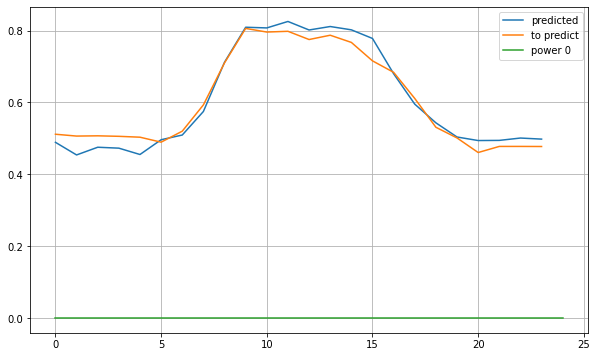

In [8]:
from sklearn import metrics

predictedValues = autoEncoderWork.predict(work_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, work_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(work_test[index]))], work_test[index], label='to predict')
ax.plot([0, len(work_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()


Come si può notare dai valori dell'MSE e dal grafico, il modello sembra ricostruire fedelmente i giorni lavorativi, tuttavia, per
avere la certezza che il modello riesca ad individuare correttamente le anomalie è necessario testarlo anche con il testing set
contenente giorni festivi normali: se l'MSE risulta molto più alto rispetto all'MSE precedentemente calcolato, allora si può assumere
che il modello funzioni correttamente.

score: 0.11157709457623181


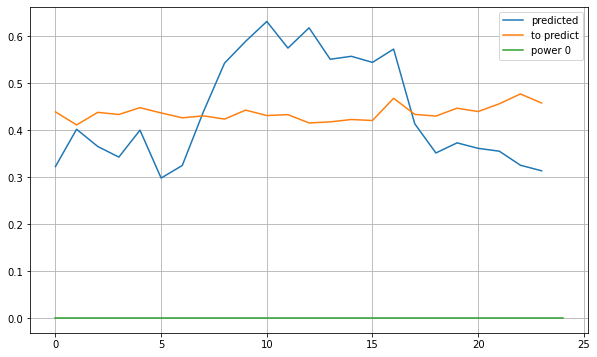

In [9]:

predictedValues = autoEncoderWork.predict(holiday_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, holiday_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(holiday_test[index]))], holiday_test[index], label='to predict')
ax.plot([0, len(holiday_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

Sia dal grafico che dall'MSE ottenuto(circa cinque volte quello precedentemente calcolato) risulta evidente come il modello
non sia in grado di ricostruire giorni lavorativi anomali.

### Autoencoder per riconoscere giorni festivi anomali
Per riconoscere le anomalie tra i giorni festivi è possibile effettuare gli stessi passaggi per allenare un nuovo autoencoder
a ricostruire giorni festivi normali.

In [10]:
SIZE_SAMPLE = 24
#enconder
activationMode = 'swish'
encoderInputHoliday = keras.Input(shape=SIZE_SAMPLE)
firstLayerEncoderHoliday = keras.layers.Dense(50, activation=activationMode, name="1")(encoderInputHoliday)
secondLayerEncoderHoliday = keras.layers.Dense(20, activation=activationMode, name="2")(firstLayerEncoderHoliday)
encoderOutputHoliday = keras.layers.Dense(2, activation=activationMode, name="3")(secondLayerEncoderHoliday)

#decoder
firstLayerDecoderHoliday = keras.layers.Dense(20, activation=activationMode, name="4")(encoderOutputHoliday)
secondLayerDecoderholiday = keras.layers.Dense(50, activation=activationMode, name="5")(firstLayerDecoderHoliday)
decoderOutputHoliday = keras.layers.Dense(24, activation=activationMode, name="6")(secondLayerDecoderholiday)

#auto encoder
autoEncoderHoliday = keras.Model(encoderInputHoliday, decoderOutputHoliday)
autoEncoderHoliday.compile(optimizer='Adam', loss='mean_squared_error')
autoEncoderHoliday.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
1 (Dense)                    (None, 50)                1250      
_________________________________________________________________
2 (Dense)                    (None, 20)                1020      
_________________________________________________________________
3 (Dense)                    (None, 2)                 42        
_________________________________________________________________
4 (Dense)                    (None, 20)                60        
_________________________________________________________________
5 (Dense)                    (None, 50)                1050      
_________________________________________________________________
6 (Dense)                    (None, 24)                1224

Il modello viene allenato con holiday_train, ovvero campioni di soli giorni festivi nominali.

In [11]:
BATCH_SIZE = 64
train = np.array(holiday_train)
autoEncoderHoliday.fit(train, train, epochs=40, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)


Di seguito viene calcolato l'MSE tra i valori originali e previsti dei giorni di holiday_test.

score: 0.01891600756987459


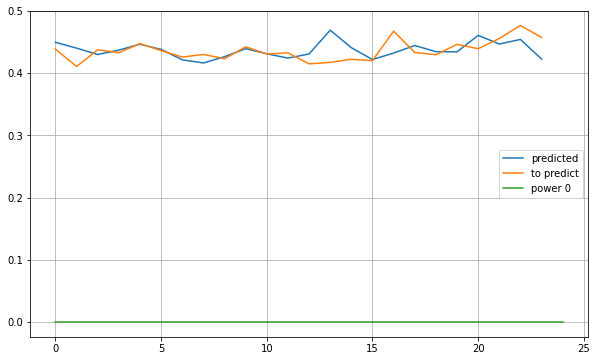

In [12]:
predictedValues = autoEncoderHoliday.predict(holiday_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, holiday_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(holiday_test[index]))], holiday_test[index], label='to predict')
ax.plot([0, len(holiday_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()


Il test mostra che l'errore misurato tramite l'MSE è intorno al 2%.

score: 0.14444885367456542


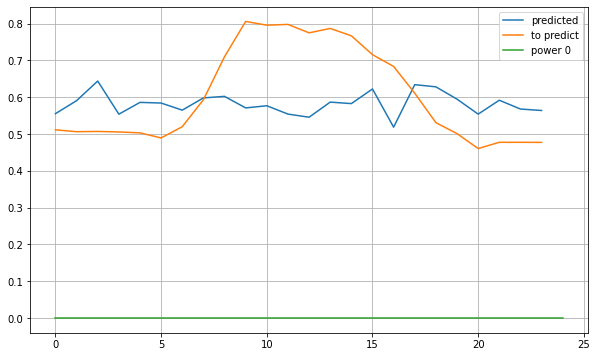

In [13]:

predictedValues = autoEncoderHoliday.predict(work_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, work_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(work_test[index]))], work_test[index], label='to predict')
ax.plot([0, len(work_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

Testando il secondo autoencoder con i giorni di work_test, è possibile notare come l'MSE calcolato sia circa 7 volte maggiore
rispetto a quello calcolato precedentemente, di conseguenza è possibile assumere che il secondo autoencoder non sia in
grado di ricostruire giorni festivi anomali.

### Tolleranze
Basandosi sulle osservazioni degli errori di ricostruzione dei singoli dati(sia anomali che non) è possibile stabilire una
tolleranza sopra la quale una ricostruzione è da considerarsi errata e che quindi il giorno ricostruito sia anomalo.

Di seguito vengono utilizzati 10 giorni festivi anomali e 10 festivi nominali per decidere la soglia per il secondo autoencoder.

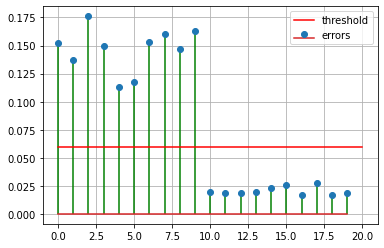

In [14]:
holidays_errors = []

for x in range(10):
    predicted = autoEncoderHoliday.predict([work_test[x]])
    holidays_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], work_test[x])))
for x in range(10):
    predicted = autoEncoderHoliday.predict([holiday_test[x]])
    holidays_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], holiday_test[x])))

THREASHOLD_HOLIDAY = 0.06

fig, ax = plt.subplots(figsize=(6, 4))
ax.stem([x for x in range(0, len(holidays_errors))], holidays_errors, 'g', label="errors")
ax.plot([0, len(holidays_errors)], [THREASHOLD_HOLIDAY, THREASHOLD_HOLIDAY], 'r', label="threshold" )
ax.grid()
ax.legend()
plt.show()


Infine vengono utilizzati 10 giorni lavorativi nominali e 10 giorni lavorativi anomali per determinare la soglia per il primo autoencoder:

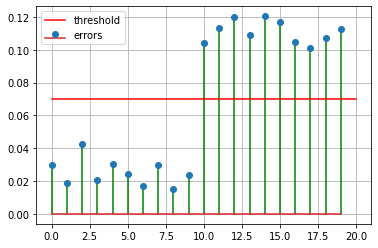

In [15]:
work_errors = []

for x in range(10):
    predicted = autoEncoderWork.predict([work_test[x]])
    work_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], work_test[x])))
for x in range(10):
    predicted = autoEncoderWork.predict([holiday_test[x]])
    work_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], holiday_test[x])))

THREASHOLD_WORK = 0.07

fig, ax = plt.subplots(figsize=(6,4))
ax.stem([x for x in range(0, len(work_errors))], work_errors, 'g', label="errors")
ax.plot([0, len(work_errors)], [THREASHOLD_WORK, THREASHOLD_WORK], 'r', label="threshold" )
ax.grid()
ax.legend()
plt.show()


Ora che sono stati allenati i modelli e sono state definite le soglie per determinare se un giorno è da considerarsi anomalo
o meno, è possibile creare una funzione che sia in grado di individuare delle anomalie.

is_anomalous_ae richiede come parametri 'd' e 'sample', dove 'd' è un oggetto pandas.date che rappresenta la data di campionamento,
mentre 'sample' è una lista di 24 campioni. La funzione restituisce un valore booleano, True se il giorno è anomalo, False altrimenti.

In [16]:
def is_anomalous_ae(d, sample):
    h = holidays.CountryHoliday('Netherlands', d.year)
    if d.day_of_week == 5 or d.day_of_week == 6 or d in h:
        prediction = autoEncoderHoliday.predict([sample])
        error = np.sqrt(metrics.mean_squared_error(prediction[0], sample))
        return error > THREASHOLD_HOLIDAY
    else :
        prediction = autoEncoderWork.predict([sample])
        error = np.sqrt(metrics.mean_squared_error(prediction[0], sample))
        return error > THREASHOLD_WORK


## K-MEANS

Il secondo approccio utilizzato per individuare delle anomalie è di utilizzare l'algoritmo k-means.
È possibile assumere che tutti i dati possano appartenere a due cluster: il primo rappresentante i giorni lavorativi, mentre
il secondo i giorni festivi.
Per individuare i centroidi verranno utilizzati nella fase di training sia i valori di work_train che di holiday_train.

In [17]:
from sklearn.cluster import KMeans

random.shuffle(all_samples)

N_CENTROIDS = 2
kmeans2 = KMeans(n_clusters=N_CENTROIDS, random_state=0).fit(all_samples)
label = kmeans2.predict(all_samples)
unique_labels = np.unique(label)

Siccome k-means a ogni run associa un'etichetta diversa allo stesso cluster, è necessario individuare i cluster dei giorni
lavorativi e festivi a run-time.

Viene fatta una previsione sui dati dei giorni lavorativi utilizzati per formare i cluster: l'etichetta dei giorni lavorativi
sarà quella restituita più spesso da k-means. La stessa operazione viene effettuata sui dati dei giorni festivi.

Se il clustering è stato effettuato correttamente, allora la maggior parte dei giorni festivi devono essere associati a una determinata etichetta,
mentre quelli lavorativi all'etichetta rimanente.

In [18]:
work_labels = kmeans2.predict(work_train)
holiday_labels = kmeans2.predict(holiday_train)

cluster_0_work = np.count_nonzero(work_labels == unique_labels[0])
cluster_1_work = np.count_nonzero(work_labels == unique_labels[1])

cluster_0_holiday = np.count_nonzero(holiday_labels == unique_labels[0])
cluster_1_holiday = np.count_nonzero(holiday_labels == unique_labels[1])

if cluster_0_work > cluster_1_work:
    real_label_work = 0
else:
    real_label_work = 1
if cluster_0_holiday > cluster_1_holiday:
    real_label_holiday = 0
else:
    real_label_holiday = 1
print("working days labeled with label 0 = {}".format(cluster_0_work))
print("working days labeled with label 1 = {}".format(cluster_1_work))
print("holidays labeled with label 0 = {}".format(cluster_0_holiday))
print("holidays labeled with label 1 = {}".format(cluster_1_holiday))


print("working days are labeled with {}".format(real_label_work))
print("holidays are labeled with {}".format(real_label_holiday))


working days labeled with label 0 = 201
working days labeled with label 1 = 0
holidays labeled with label 0 = 0
holidays labeled with label 1 = 88
working days are labeled with 0
holidays are labeled with 1


Una volta definite le labels dei cluster, è possibile determinare se un determinato giorno è anomalo o meno. Conoscendo il giorno
di campionamento, se la tipologia di giorno differisce dal cluster assegnato, allora il giorno analizzato è da
considerarsi anomalo.

In [19]:
prediction_anomalous_holiday = kmeans2.predict(anomalous_holiday_samples)[0]
prediction_anomalous_work = kmeans2.predict(anomalous_work_samples)[0]

print("Kmeans recognize an anomalous working day : {}".format(prediction_anomalous_work != real_label_work))
print("Kmeans recognize an anomalous holiday : {}".format(prediction_anomalous_holiday != real_label_holiday))

Kmeans recognize an anomalous working day : True
Kmeans recognize an anomalous holiday : True


La seguente funzione è in grado di individuare giorni anomali usando k-means

I parametri richiesti sono 'd' e 'samples' dove 'd' è un pandas.date object che rappresenta la data di campionamento, mentre
'samples' è un vettore di 24 campioni. Se il giorno è anomalo, la funzione restituisce True, altrimenti False.

In [20]:
def is_anomalous_kmeans(d, sample):
    h = holidays.CountryHoliday('Netherlands', d.year)
    prediction = kmeans2.predict(sample)
    if d.day_of_week == 5 or d.day_of_week == 6 or d in h:
        return prediction != real_label_holiday
    else :
        return prediction != real_label_work

## LSTM

Un altro metodo che può essere utilizzato per individuare giorni anomali può essere quello di utilizzare un LSTM che,
dati in ingresso i campioni degli ultimi sette giorni è in grado di prevedere i consumi del giorno successivo.
Confrontando i consumi previsti con i consumi effettivi, se l'errore risulta essere relativamente alto, allora è possibile stabilire
che il giorno analizzato è un'anomalia.

Allenare l'LSTM a riconoscere anomalie sapendo i consumi degli ultimi sette giorni equivale a determinare quale sia il prossimo
giorno della settimana data una sequenza di sette giorni: di conseguenza per poter avere delle previsioni accurate sarà necessario
utilizzare delle settimane che non contengano giorni anomali o festività.
Per comprendere meglio il problema, di seguito viene fornito un esempio.

Siano L un giorno con consumi bassi e H un giorno con consumi alti.

Data la sequenza L L H H H H H è lecito supporre che il giorno successivo sia un sabato.
Data la sequenza anomala L L L H H H H non è possibile stabilire il giorno successivo, infatti la sequenza L L L potrebbe
rappresentare la sequenza temporale Venerdì(festa), Sabato, Domenica oppure la sequenza Sabato, Domenica, Lunedì(festa), dunque
il giorno successivo potrebbe essere sia un Venerdì(giorno lavorativo) che un Sabato(giorno festivo).

In [21]:
#cleaning samples from weeks that contains an anomalous day
def append_elements_of_list(from_array, to_array):
    for element in from_array:
        to_array.append(element)

anomalous_days = []
append_elements_of_list(anomalousWorkingDays, anomalous_days)
append_elements_of_list(anomalousHolidays, anomalous_days)
append_elements_of_list(holidays_netherlands, anomalous_days)

I campioni di samples che non sono contenuti in settimane anomale, vengono copiati in nuovo vettore 'cleaned_samples'.

In [22]:
from datetime import timedelta

cleaned_samples = []
anomalous_weeks = []
start = 0
SPAN = DAY * 7
for date in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='7D'):
    is_anomalous_week = False
    for day_of_week in pd.date_range(start=date, end=(date + timedelta(days=7)), freq = '1D'):
        if day_of_week in anomalous_days:
            is_anomalous_week = True
    if not is_anomalous_week:
        append_elements_of_list(samples[start : start + SPAN], cleaned_samples)
    else:
        append_elements_of_list(samples[start : start + SPAN], anomalous_weeks)
    start += SPAN
cleaned_samples = np.array(cleaned_samples[: int(len(cleaned_samples) / SPAN) * SPAN])
cleaned_samples = cleaned_samples.reshape(1, cleaned_samples.shape[0])
print(cleaned_samples.shape)

(1, 29568)


Una volta rimossi i dati delle settimane anomale, vengono create le liste 'window_samples' e 'labels',
dove la prima è una lista di 56 elementi che rappresentano i consumi dell'ultima settimana, mentre la seconda è costituita
da 8 elementi che rappresentano i consumi del giorno successivo.

Come si può notare dai numeri, si assume che un campionamento avvenga ogni 3 ore per evitare di avere degli input troppo
granulari. Siccome il campionamento avviene ogni 15 minuti, ogni elemento i-esimo delle liste precedenti rappresenta una
media dei dati campionati nell'arco di 3 ore.

In [23]:
window_samples = []
labels = []
SAMPLES_PER_DAY = int(24 / 3)
WINDOW_SIZE = 7

for starting_window in range(0, len(cleaned_samples[0]), DAY):
    window = []
    label = []
    index = 0
    for x in range(WINDOW_SIZE * SAMPLES_PER_DAY):
        window.append(cleaned_samples[0][starting_window + SAMPLES_PER_HOUR * index : starting_window + SAMPLES_PER_HOUR * ( index + 3)].mean())
        index += 3
    for x in range(SAMPLES_PER_DAY):
        label.append(cleaned_samples[0][starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * index : starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * (index + 3)].mean())
        index += 3
    window_samples.append(window)
    labels.append(label)
labels = labels[: len(labels) - 14]
window_samples = window_samples[: len(window_samples) - 14]
print(len(window_samples))


294


<ipython-input-23-b2f958b1b6c8>:14: RuntimeWarning: Mean of empty slice.
  label.append(cleaned_samples[0][starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * index : starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * (index + 3)].mean())
c:\users\mvcim\onedrive\desktop\vlad\my_jupiter_notebooks\paper2\venv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-23-b2f958b1b6c8>:11: RuntimeWarning: Mean of empty slice.
  window.append(cleaned_samples[0][starting_window + SAMPLES_PER_HOUR * index : starting_window + SAMPLES_PER_HOUR * ( index + 3)].mean())


Di seguito viene rappresentata una settimana non anomala e il suo giorno successivo, ovvero l'input dell'LSTM e ciò che ci
si aspetta che sia in grado di prevedere.

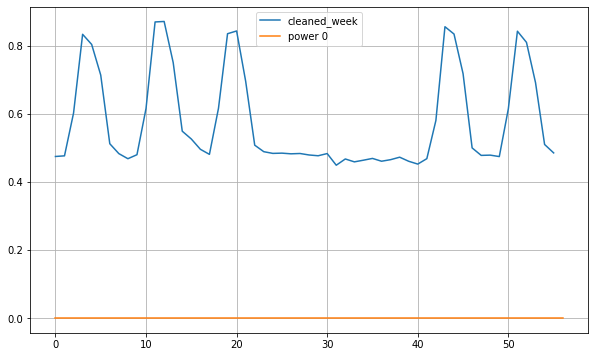

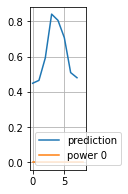

In [24]:
#plotting cleaned samples
index = 0
fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(window_samples[index]))], window_samples[index], label="cleaned_week")
ax.plot([0, len(window_samples[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(1,3))
ax.plot([x for x in range(0, len(labels[index]))], labels[index], label="prediction")
ax.plot([0, len(labels[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

A causa delle scarse dimensioni del dataset, il modello non è in grado di riconoscere correttamente
i consumi del sabato: anziché prevedere dei consumi bassi, vengono previsti dei consumi elevati come quelli di un giorno
lavorativo. Per far fronte a questa problematica si è deciso di utilizzare una tecnica di data augmentation, ovvero
di raddoppiare le finestre settimanali che hanno i campioni
dei giorni che vanno dal sabato al venerdì e come valori da prevedere i consumi del sabato. Così facendo si va ad aumentare
significativamente il numero di dati necessari all'apprendimento dei consumi del sabato.

In [25]:
duplicated_windows = []
duplicated_labels = []

#duplicating some data that should anticipate a saturday.
for i in range(3, len(window_samples), 7):
    window_samples.append(window_samples[i])
    labels.append(labels[i])
    duplicated_windows.append(window_samples[i])
    duplicated_labels.append(labels[i])

append_elements_of_list(window_samples, duplicated_windows)
append_elements_of_list(labels, duplicated_labels)
window_samples = duplicated_windows
labels = duplicated_labels


Di seguito vengono create delle liste per il training e il testing del modello.

In [26]:
train_weeks = []
train_labels = []
testing_weeks = []
testing_labels = []

training_size = int(len(labels) * PERCENTAGE)
for index in range(training_size):
    train_weeks.append(window_samples[index])
    train_labels.append(labels[index])
for index in range(training_size, len(labels)):
    testing_weeks.append(window_samples[index])
    testing_labels.append(labels[index])


def search_nan(arr):
    for element in arr:
        for x in element:
            if math.isnan(x):
                return True
    return False


Gli LSTM layer richiedono degli input tridimensionali(samples, time steps, features), quindi il set di training deve
essere ridimensionato correttamente.

In [27]:
def reshape_set(set_to_convert, features):
    return set_to_convert.reshape((set_to_convert.shape[0], set_to_convert.shape[1], features))


train_weeks = np.array(train_weeks)
train_labels = np.array(train_labels)
testing_weeks = np.array(testing_weeks)
testing_labels = np.array(testing_labels)

print(search_nan(train_weeks))
print(search_nan(train_labels))
print(search_nan(testing_weeks))
print(search_nan(testing_labels))

FEATURES = 1

training_set = reshape_set(train_weeks, FEATURES)
testing_set = reshape_set(testing_weeks, FEATURES)

False
False
False
False


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import LSTM, Dropout

ACTIVATION_MODE = 'tanh'
hourForecaster = Sequential()

BATCH_SIZE = 256
NUM_SAMPLES = len(training_set)
n_steps_in = 8 * 7
drop_out = 0.1

model = Sequential()
model.add(LSTM(100, activation=ACTIVATION_MODE, return_sequences=True, input_shape=(n_steps_in, FEATURES)))
model.add(Dropout(drop_out))
model.add(LSTM(100, activation=ACTIVATION_MODE))
model.add(Dropout(drop_out))
model.add(Dense(50, activation=ACTIVATION_MODE))
model.add(Dropout(drop_out))
model.add(Dense(20, activation=ACTIVATION_MODE))
model.add(Dropout(drop_out))
model.add(Dense(8, activation=ACTIVATION_MODE))

model.compile(optimizer = Adam(learning_rate=0.001), loss='mse')
#best parameters :  activation mode tanh
#                   learning rate = 0.001
#                   batch_size 256(with duplicated saturdays)
#                   loss mse
#dropout            0.1
#score              7,5%
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 56, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 56, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)               

In [29]:
model.fit(training_set, train_labels, epochs=60, verbose=0, validation_data=(testing_set, testing_labels))
#validation_data=(testing_set, testing_labels)

Per verificare che il training abbia funzionato, possiamo utilizzare il testing set e calcolare l'MSE tra le labels dei
test e le previsioni ottenute dal modello.

In [30]:
def convert_predicted_value(x):
    new_x = []
    for element in x:
        new_x.append(element[-1])
    return new_x

to_predict = testing_set
labels_to_predict = testing_labels
to_predict = to_predict.reshape((to_predict.shape[0], to_predict.shape[1], FEATURES))

predictedValues = model.predict(to_predict)

score = np.sqrt(metrics.mean_squared_error(predictedValues, labels_to_predict))
print("score: {}".format(score))


labels_to_predict = np.array(labels_to_predict)
labels_to_predict = labels_to_predict.reshape(1, labels_to_predict.shape[0] * labels_to_predict.shape[1])
predictedValues = predictedValues.reshape(1, predictedValues.shape[0] * predictedValues.shape[1])


score: 0.03849663263258331


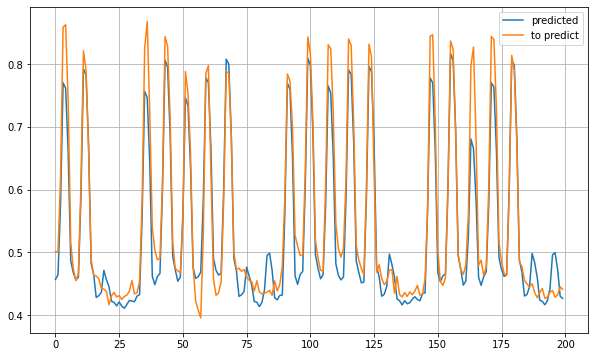

In [31]:
START = 0
END = 200

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[0][START:END]))], predictedValues[0][START:END], label="predicted")
ax.plot([x for x in range(0, len(labels_to_predict[0][START:END]))], labels_to_predict[0][START:END], label='to predict')
ax.grid()
ax.legend()
plt.show()



### Soglia di tolleranza
Ora che è stato allenato correttamente il modello, bisogna determinare la soglia di errore per cui si può considerare che
il giorno previsto sia un'anomalia.
Di seguito vengono osservati 10 errori per previsioni corrette e 10 errori per previsioni errate.

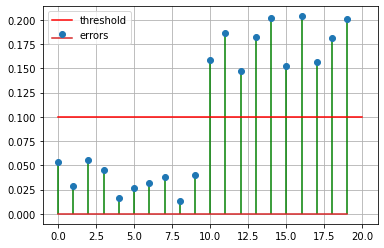

In [32]:
errors = []
span = 25
testing_set = testing_set.reshape(testing_set.shape[0], testing_set.shape[1])
for x in range(10):
    to_predict = np.array(testing_set[x + span])
    to_predict = to_predict.reshape(1, 56, 1)
    prevision = model.predict(to_predict)
    lbs = np.array(labels_to_predict)
    lbs = lbs.reshape(int(labels_to_predict.shape[1] / 8), 8)
    lb = np.array(lbs[x + span])
    lb = lb.reshape(1, 8)
    errors.append(np.sqrt(metrics.mean_squared_error(prevision, lb)))

m_index = 4
for x in range(10):
    if x == 5:
        m_index = 6
    predicted_labels = np.array(predictedValues)
    predicted_labels = predicted_labels.reshape(int(predicted_labels.shape[1] / 8), 8)
    low_demand = predicted_labels[x + m_index]
    high_demand = predicted_labels[-1 - x]
    errors.append(np.sqrt(metrics.mean_squared_error(high_demand, low_demand)))

THREASHOLD = 0.10

fig, ax = plt.subplots(figsize=(6,4))
ax.stem([x for x in range(0, len(errors))], errors, 'g', label="errors")
ax.plot([0, len(errors)], [THREASHOLD, THREASHOLD], 'r', label="threshold" )
ax.grid()
ax.legend()
plt.show()



Infine viene definita una funzione per individuare i giorni anomali con l'uso dell'LSTM.
La funzione is_anomalous_lstm richiede come parametri 'd', 'samples, 'curr_sample', dove d è un pandas.date
object, mentre samples è un array di 56 elementi rappresentanti i campioni degli ultimi sette giorni, infine
curr_sample è un vettore di otto elementi, ovvero i campioni del giorno da analizzare.
Il metodo restituisce True se il giorno dato è anomalo, altrimenti False.

In precedenza si è deciso di eliminare dal training le settimane contenenti giorni festivi, di conseguenza,
se il modello è stato allenato correttamente, dovrebbe individuare le festività che cadono nei giorni lavorativi
come delle anomalie. Per evitare che ciò accada è possibile verificare che il giorno da analizzare sia una festività
in un giorno lavorativo: nel caso in cui ciò si verificasse si può assumere che se il giorno è anomalo se l'errore è basso,
anziché alto.

In [33]:
def is_anomalous_lstm(d, samples, curr_sample):
    h = holidays.CountryHoliday('Netherlands', d.year)
    x = np.array(samples)
    x = x.reshape(1, 56, 1)
    p = model.predict(x)
    y = np.array(curr_sample)
    y = y.reshape(1, 8)
    err = np.sqrt(metrics.mean_squared_error(p, y))
    if d in h and not (d.day_of_week == 5 or d.day_of_week == 6):
        return err < THREASHOLD
    else:
        return err > THREASHOLD
